In [1]:
from datasets import load_dataset

ds = load_dataset("Bingsu/Cat_and_Dog")

Using the latest cached version of the dataset since Bingsu/Cat_and_Dog couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/mhurben/.cache/huggingface/datasets/Bingsu___cat_and_dog/default/0.0.0/77396f1031920d1c116ec6d63ac397ff6aa492d3 (last modified on Sat Jul 27 16:39:35 2024).


In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2000
    })
})

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset

import matplotlib.pyplot as plt
import numpy as np
import time

#from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_device(device)

cuda


In [5]:
itol = {
    0: 'GATO',
    1: 'PERRO'
}

In [6]:
data_path = {
    'train': './cat_or_dog/training_set',
    'dev': './cat_or_dog/test_set',
    'test1': './cat_or_dog/single_prediction',
    'test2': './cat_or_dog/cheetos_luck',
}

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['labels']  # Use the correct key for label

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
trans = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Grayscale(num_output_channels=1),
    #transforms.Normalize(mean = mean, std = std)
])

In [9]:
train_dataset = CustomDataset(ds['train'], transform=trans)

In [10]:
x_data_train = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))], dim=0).to(torch.float32)
print(x_data_train.shape)

torch.Size([8000, 3, 64, 64])


In [11]:
all_images = x_data_train.view(8000, 3, -1)
all_images.shape

torch.Size([8000, 3, 4096])

In [12]:
mean = all_images.mean(dim=(0, 2))
std = all_images.std(dim=(0, 2))
mean, std

(tensor([0.4697, 0.4374, 0.4009]), tensor([0.2640, 0.2551, 0.2551]))

In [13]:
trans = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize(mean = mean, std = std)
])

In [14]:
g_cuda = torch.Generator(device = 'cuda')

train_dataset = CustomDataset(ds['train'], transform = trans)
dev_dataset = CustomDataset(ds['test'], transform = trans)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, generator = g_cuda)
dev_loader = DataLoader(dev_dataset, batch_size = 32, shuffle = True, generator = g_cuda)

In [15]:
x_data_dev = torch.stack([dev_dataset[i][0] for i in range(len(dev_dataset))], dim=0).to(torch.float32)

In [16]:
type(x_data_dev)

torch.Tensor

In [17]:
y_data_dev = []
for i in range(len(dev_dataset)):
    label = dev_dataset[i][1]
    y_data_dev.append(label)
y_data_dev = torch.tensor(y_data_dev)

In [18]:
len(x_data_dev), len(y_data_dev)

(2000, 2000)

['GATO', 'PERRO', 'GATO', 'PERRO', 'PERRO', 'PERRO']


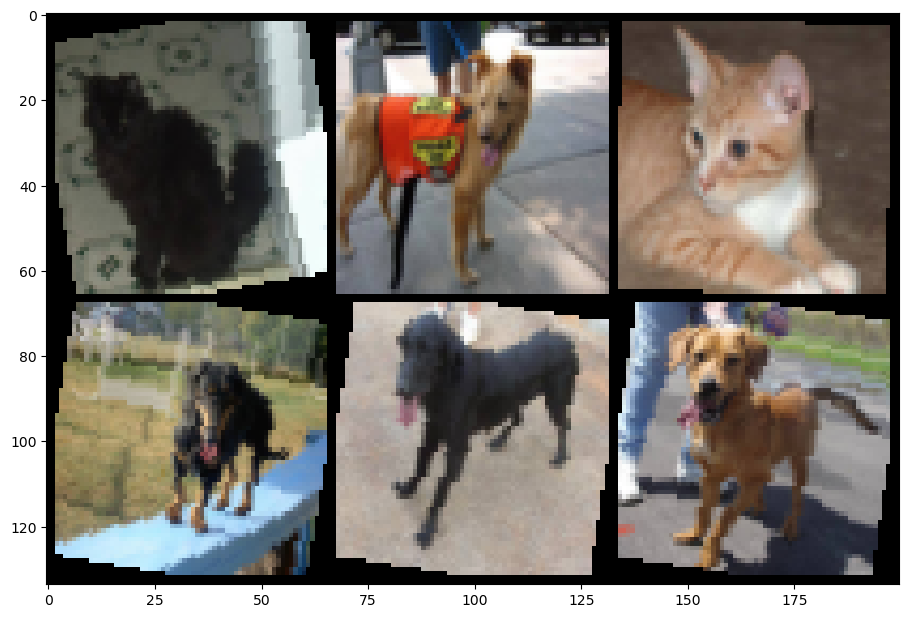

In [19]:
def image_plot():
    l = []
    loader = torch.utils.data.DataLoader(train_dataset, batch_size = 6, shuffle = True, generator = g_cuda)

    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11, 11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    for e in labels:
        l.append(itol[e.item()])
    print(l)

image_plot()

In [20]:
Image_Width = 64
Image_Height = 64

In [21]:
class Miau(nn.Module):
    def __init__(self):
        super(Miau, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.25)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.drop2 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.drop3 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (Image_Width // 8) * (Image_Height // 8), 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.drop4 = nn.Dropout(0.5)
        #self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.drop1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.drop2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.drop3(x)
        #print(x.shape)
        
        x = self.flatten(x)
        #print(x.shape)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.drop4(x)
        #x = F.relu(self.bn4(self.fc2(x)))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

In [22]:
model = Miau()

In [23]:
cross = F.cross_entropy

optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [24]:
def eval_model(x_data_dev, y_data_dev):
    x_data_dev = x_data_dev.to(device)
    y_data_dev = y_data_dev.to(device)
    result = model(x_data_dev)
    
    loss = cross(result, y_data_dev)

    _, predicted = torch.max(result, 1)

    y_true_labels = [itol[label.item()] for label in y_data_dev]
    y_pred_labels = [itol[label.item()] for label in predicted]

    report = classification_report(y_true_labels, y_pred_labels, zero_division = 0)
    print(report)

In [25]:
for epoch in range(15):
    start_time = time.time()
    for image_batch, label_batch in train_loader:
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        #FORWARD 
        outputs = model(image_batch)
        #print(outputs.shape)
        loss = cross(outputs, label_batch)
        
        #BACKWARD AND OPTIM
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    print(f'Epoch número {epoch}')
    eval_model(x_data_dev, y_data_dev)
    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'Epoch número {epoch}, ha tardat {epoch_time / 60}')

Epoch número 0
              precision    recall  f1-score   support

        GATO       0.66      0.75      0.70      1000
       PERRO       0.71      0.61      0.65      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000

Epoch número 0, ha tardat 0.403523067633311
Epoch número 1
              precision    recall  f1-score   support

        GATO       0.71      0.71      0.71      1000
       PERRO       0.71      0.70      0.71      1000

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000

Epoch número 1, ha tardat 0.3979193607966105
Epoch número 2
              precision    recall  f1-score   support

        GATO       0.74      0.72      0.73      1000
       PERRO       0.73      0.74      0.74      1000

    accuracy                           0.73     

KeyboardInterrupt: 

In [ ]:
torch.save(model, './miauNET2.pth')

In [26]:
test_data_for_print = torchvision.datasets.ImageFolder(root = data_path['test1'])

test_data = torchvision.datasets.ImageFolder(root = data_path['test1'], transform = trans)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1, shuffle = False, generator = g_cuda)

In [27]:
def plot_image(img_tensor):

    #image_np = img_tensor.permute(1, 2, 0).numpy()

    # Plot the image
    plt.imshow(img_tensor)
    plt.axis('off')  # Hide axes
    plt.show()

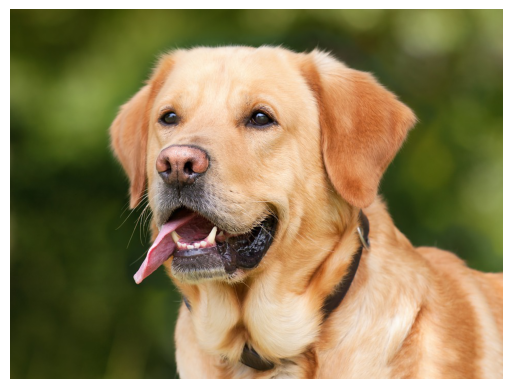

Creo que la foto es de un: PERRO


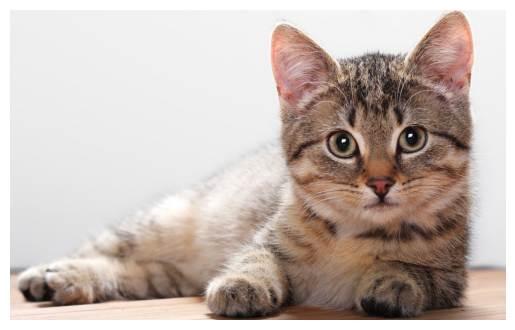

Creo que la foto es de un: GATO


In [28]:
for i, (image, label) in enumerate(test_loader):
    model.eval()
    image = image.to(device)
    label = image.to(label)
    
    plot_image(test_data_for_print[i][0])
    #print(image.shape)
    result = model(image)
    
    _, predicted = torch.max(result, 1)
    
    print(f'Creo que la foto es de un: {itol[predicted.item()]}')